#Digitalización de un centro de tratamiento de residuos mediante algoritmos de predicción.

PROYECTO
presentado por
Fco. Javier Pérez Vázquez
bajo la supervisión de 
Dra. Idoia Ochoa
Diciembre 2022


El proyecto consiste en la digitalización un centro de tratamiento de residuos y sus procesos para favorecer la circularidad de estos y eficiencia de la planta.

Los retos que se plantean vienen dados al diseñar el proyecto de manera que sea escalable a otros centros y a la implantación de nuevas tecnologías como Machine Learning o Big data. Para la detección de posibles anomalías en la selección de residuos y predicción de datos.


A continuación se muestra un extracto del código utilizado para el desarrollo del proyecto.

#Modelo ARIMA

##Librerías utilizadas

In [ ]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.6 MB/s 
     |████████████████████████████████| 9.9 MB 44.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('fivethirtyeight') 
import seaborn as sns
import pandas as pd



%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict

import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from random import random
import datetime
import scipy
from scipy import stats

##Datos

In [4]:
url_todo = 'https://raw.githubusercontent.com/Javimitri/data/main/AYU_RU_TODO.csv'

df2 = pd.read_csv(url_todo) #sin agrupar
df2 = df2.groupby("fecha").sum() #agrupar todas las pesadas por fecha

#########################APLICAR ESCALA##################################
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
df0 = min_max_scaler.fit_transform(df2)
df2 = pd.DataFrame(df0, columns=df2.columns)
df2 = df2[1:len(df2)]
#########################################################################

df_mas = df2['neto']

###Representación

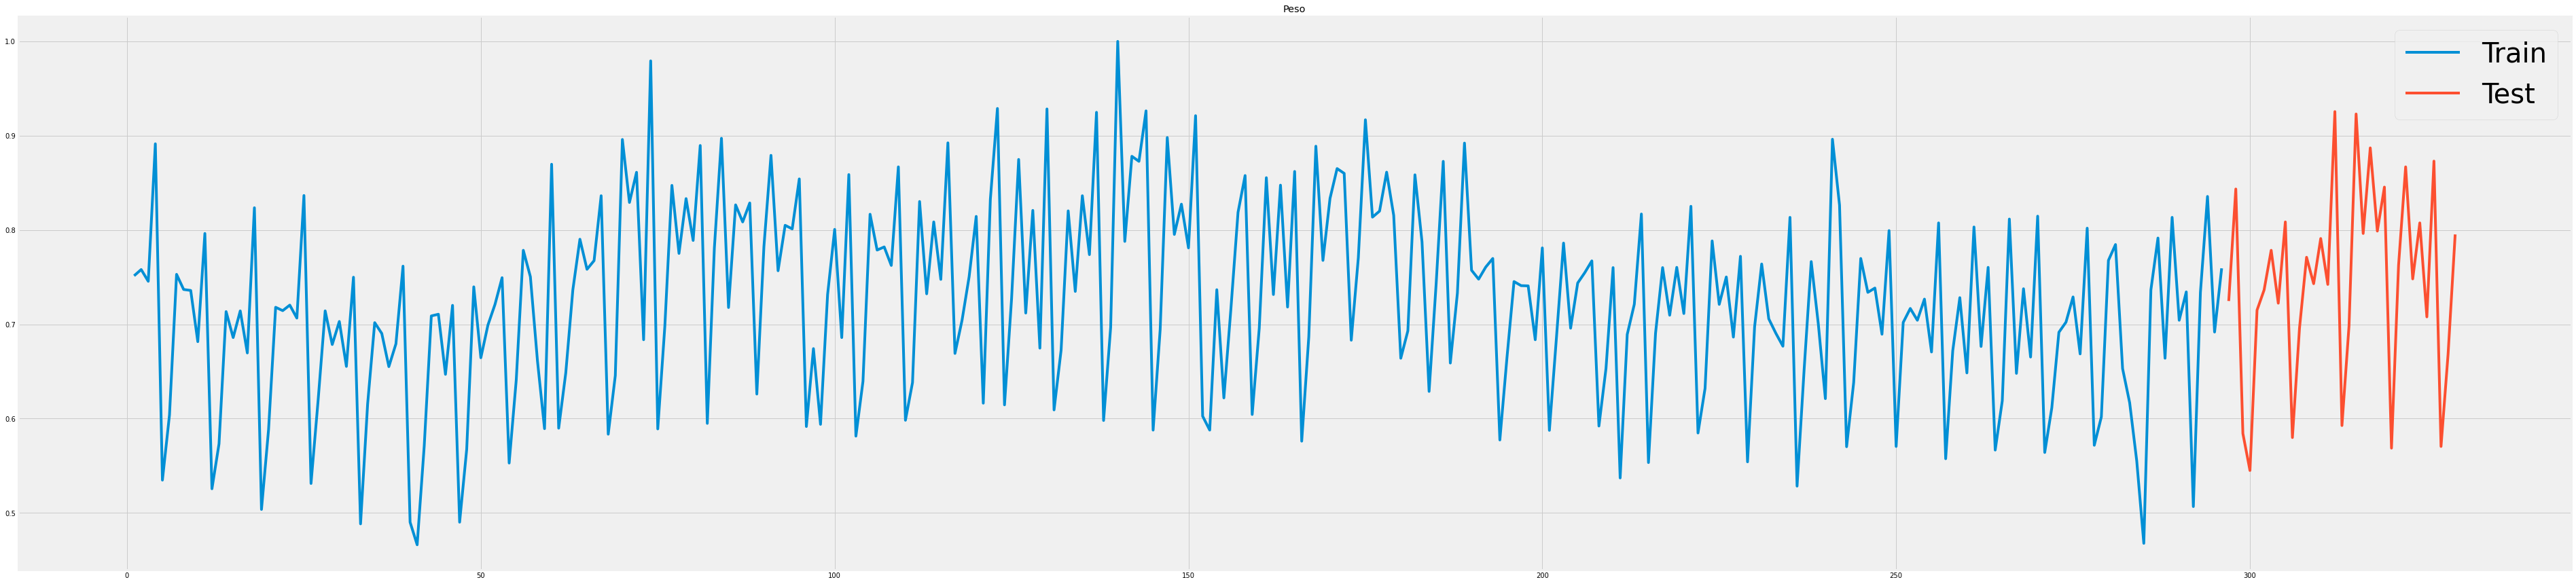

In [ ]:
train_data = df_mas[0:int(len(df_mas)*0.9)]
train_data2 = df_mas[int(len(df_mas)*0.8):int(len(df_mas)*0.9)]
test_data = df_mas[int(len(df_mas)*0.9):]

#Visualización
plt.figure(figsize=(60, 15))
plt.plot(train_data, label = 'Train')
plt.plot(test_data, label = 'Test')
plt.title('Peso')
plt.grid(True)
plt.legend(prop={'size': 40})

###Prueba ADF (Dickey-Fuller aumentada) 

In [ ]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_mas.dropna())

print("ADF :",result[0])
print("p-valor :",result[1])
print("num de lags :",result[2])
print("num de observaciones usadas para la regresión de ADR y los cálculos de los valores críticos :",result[3])
print("valores criticos: ")
for key, val in result[4].items():
  print("\t",key,": ", val)

ADF : -2.4227739471266903
p-valor : 0.13541152271164053
num de lags : 14
num de observaciones usadas para la regresión de ADR y los cálculos de los valores críticos : 314
valores criticos: 
	 1% :  -3.4513486122290717
	 5% :  -2.870789013306053
	 10% :  -2.5716978530569192


###ARIMA Model

In [ ]:
#Función auto_arima
stepwise_fit_mas=auto_arima(df_mas, start_p=0, 
                      start_q=0, test='adf',
                      m=7, d=1,
                      information_criterion='aic',
                      method='nm',
                      seasonal=True,
                      trace=True, #logs 
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-740.917, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-348.094, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-700.223, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-696.577, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-350.094, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-480.584, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-622.439, Time=0.27 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-718.785, Time=0.45 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-722.283, Time=0.48 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-554.222, Time=0.43 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-683.069, Time=0.47 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=-740.806, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-784.923, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-564.459, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept

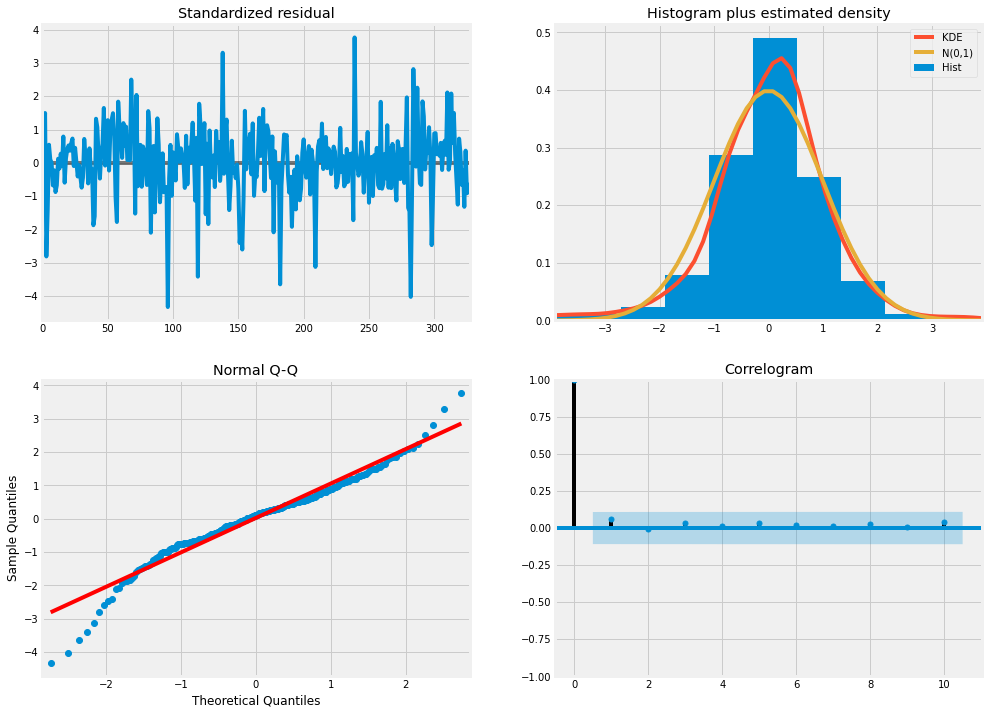

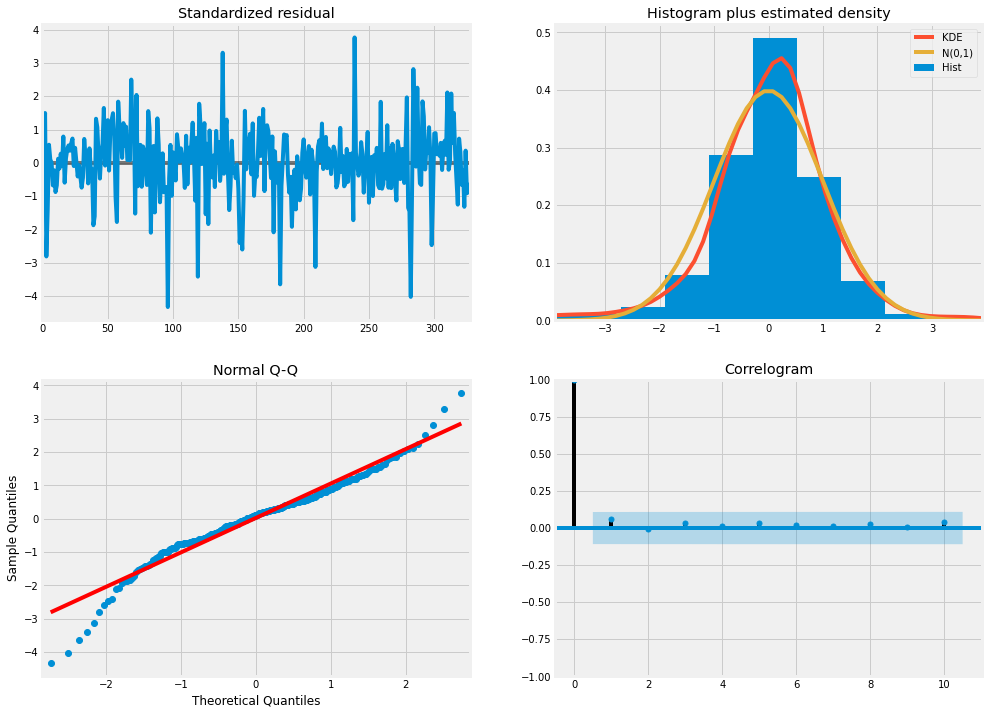

In [ ]:
#Estadísticas del modelo
stepwise_fit_mas.plot_diagnostics(figsize=(15,12))

In [ ]:
#Prueba de aumento de orden para mejorar el modelo
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train = df_mas[0:int(len(df_mas)*0.92)]
train2 = df_mas[int(len(df_mas)*0.8):int(len(df_mas)*0.9)]
test = df_mas[int(len(df_mas)*0.92):]

history = [x for x in train]
predictions_2 = list() #Va cambiando predictions_X por cada prueba
###############################PRUEBAS DE PARAMETROS###############################
for t in range(len(test)):
    #model = SARIMAX(history, order=(0, 1, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False) #modelo autoARIMA
    #model = SARIMAX(history, order=(0, 1, 2), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False) #modelo 2
    #model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False) #modelo 3
    model = SARIMAX(history, order=(0, 1, 1), seasonal_order=(1, 0, 2, 7), enforce_stationarity=False, enforce_invertibility=False) #modelo  PFM

    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_2.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
print('Test MAE:', mean_absolute_error(predictions_2, test))
print('Test MSE:',mean_squared_error(predictions_2, test))
print('Test RMSE:',sqrt(mean_squared_error(predictions_2, test)))
mae_2=mean_absolute_error(predictions_2, test) #Va cambiando mae_X por cada prueba
mse_2=mean_squared_error(predictions_2, test) #Va cambiando mse_X por cada prueba
test = list(test)

'''fig = plt.subplots(1, 1,figsize=(60,15))
#plt.plot(train_data2, label = 'train')
plt.plot(predictions_1, label = 'Pred')
plt.plot(test, label = 'Test')
plt.legend(prop={'size': 40})'''


predicted=0.725217, expected=0.778486
predicted=0.713767, expected=0.722406
predicted=0.797820, expected=0.808565
predicted=0.585308, expected=0.579913
predicted=0.652499, expected=0.695896
predicted=0.772085, expected=0.771094
predicted=0.719751, expected=0.743054
predicted=0.750215, expected=0.790976
predicted=0.734914, expected=0.742289
predicted=0.816533, expected=0.925567
predicted=0.623056, expected=0.592659
predicted=0.693034, expected=0.698445
predicted=0.801080, expected=0.923018
predicted=0.770844, expected=0.796329
predicted=0.803184, expected=0.887076
predicted=0.796732, expected=0.798878
predicted=0.887208, expected=0.845526
predicted=0.653020, expected=0.568697
predicted=0.717677, expected=0.762682
predicted=0.845427, expected=0.866939
predicted=0.786155, expected=0.748152
predicted=0.813019, expected=0.807545
predicted=0.783182, expected=0.707877
predicted=0.851001, expected=0.873056
predicted=0.628483, expected=0.570482
predicted=0.709247, expected=0.668621
predicted=0.

"fig = plt.subplots(1, 1,figsize=(60,15))\n#plt.plot(train_data2, label = 'train')\nplt.plot(predictions_1, label = 'Pred')\nplt.plot(test, label = 'Test')\nplt.legend(prop={'size': 40})"

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  328
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                 444.510
Date:                                Wed, 12 Oct 2022   AIC                           -879.020
Time:                                        20:44:16   BIC                           -860.321
Sample:                                             0   HQIC                          -871.546
                                                - 328                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8170      0.030    -27.000      0.000      -0.876      -0.758
ar.S.L7        0.9956      0.004    244.366      0.000       0.988       1.004
ma.S.L7       -0.9206      0.066    -14.033      0.000      -1.049      -0.792
ma.S.L14      -0.0380      0.070     -0.546      0.585      -0.174       0.098
sigma2         0.0032      0.000     17.712      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               103.38
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.46
Prob(H) (two-sided):                  0.66   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

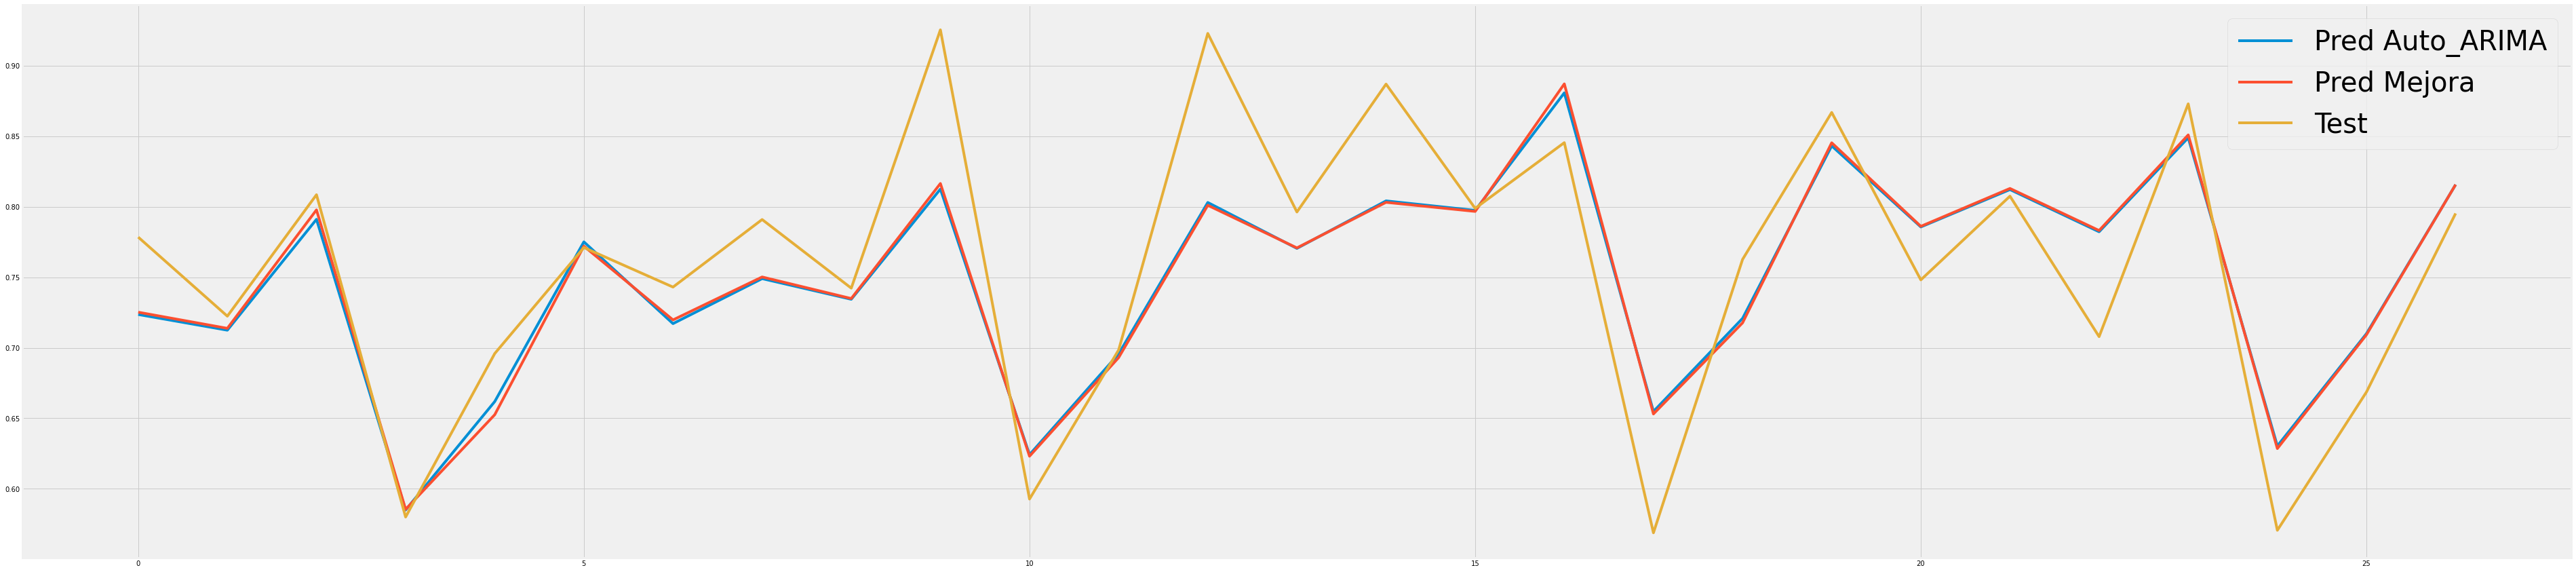

In [ ]:
fig = plt.subplots(1, 1,figsize=(60,15))

###############################COMPARATIVA DE MODELOS###############################
#plt.plot(predictions_1, label = 'Pred Auto_ARIMA') #Va cambiando predictions_X por cada prueba
#plt.plot(predictions_2, label = 'Pred Mejora') #Va cambiando predictions_X por cada prueba
#plt.plot(predictions_3, label = 'Pred (0, 1, 2)(2, 0, 2)') #Va cambiando predictions_X por cada prueba
plt.plot(test, label = 'Test')
plt.legend(prop={'size': 40})

In [ ]:
#Estudio de métricas de error
print("Modelo 1")
print('Test MAE:', mae_1)
print('Test MSE:',mse_1)
print("Modelo 2")
print('Test MAE:', mae_2)
print('Test MSE:',mse_2)
print("Modelo 3 order=(0, 1, 1), seasonal_order=(1, 0, 2, 7)")
print('Test MAE:', mae_3)
print('Test MSE:',mse_3)

Modelo 1
Test MAE: 0.038065574457795716
Test MSE: 0.0024828576848270993
Modelo 2
Test MAE: 0.03794829932649491
Test MSE: 0.002481556273658243


'print("Modelo 3 order=(0, 1, 1), seasonal_order=(1, 0, 2, 7)")\nprint(\'Test MAE:\', mae_3)\nprint(\'Test MSE:\',mse_3)'

In [ ]:
model_fit.plot_diagnostics(figsize=(15,12))

#Modelo RFR

##Librerías utilizadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

##Datos

In [3]:
window=5
url_todo='https://raw.githubusercontent.com/Javimitri/data/main/TODO_RU.csv'
df_mas=pd.read_csv(url_todo)
df_mas = df_mas[1:len(df_mas)]
df_mas=df_mas[['id','neto']]

#########################APLICAR ESCALA##################################
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
df0 = min_max_scaler.fit_transform(df_mas)
df_mas = pd.DataFrame(df0, columns=df_mas.columns)
df_mas = df_mas[1:len(df_mas)]
#########################################################################

df_mas.tail()

,id,neto
324,0.987805,0.452722
325,0.990854,0.762178
326,0.993902,0.195320
327,0.996951,0.379179
328,1.000000,0.616523


In [ ]:
train = df_mas[0:int(len(df_mas)*0.9)]
test = df_mas[int(len(df_mas)*0.9):]

##RFR Model

In [ ]:
x_train = train.iloc[:, 1:2].values #neto
y_train = train.iloc[:, 0].values #id
x_test = test.iloc[:, 1:2].values #neto
y_test = test.iloc[:, 0].values #id

###############################PRUEBAS DE PARAMETROS###############################
# Ajuste de Random Forest Regression al conjunto de datos 
#regressor = RandomForestRegressor(n_estimators = 50, random_state = 0, criterion="absolute_error", min_samples_split=100, max_depth=None)#1
#regressor = RandomForestRegressor(n_estimators = 200, random_state = 0, criterion="absolute_error", min_samples_split=100, max_depth=None)#2
#regressor = RandomForestRegressor(n_estimators = 20, random_state = 0, criterion="absolute_error", min_samples_split=100, max_depth=None)#3
#regressor = RandomForestRegressor(n_estimators = 10, random_state = 0, criterion="absolute_error", min_samples_split=100, max_depth=None)#4


#regressor = RandomForestRegressor(n_estimators = 2000, criterion="absolute_error", min_samples_split=15, max_depth=10, max_features = 'auto')#4
regressor = RandomForestRegressor(n_estimators = 10, criterion="absolute_error", min_samples_split=150, max_depth=10)#auto
#regressor = RandomForestRegressor(n_estimators = 10, criterion="squared_error", min_samples_split=100, max_depth=6)#2
#regressor = RandomForestRegressor(n_estimators = 10, criterion="absolute_error", min_samples_split=100, max_depth=6)#3
#regressor = RandomForestRegressor(n_estimators = 10, criterion="absolute_error", min_samples_split=100, max_depth=3)#4


regressor.fit(x_train, y_train)
# Visualización de los resultados de Random Forest Regresion
# un rango para crear un rango de valores 
# desde el valor mínimo de x hasta el máximo 
# valor de x con una diferencia de 0.01 
# entre dos valores consecutivos 
'''X_grid = np.arange(min(x_test), max(x_test), 0.01)'''
# remodelar para remodelar los datos en una matriz len(X_grid)*1, 
# es decir, para hacer una columna a partir del valor de 
'''X_grid = X_grid.reshape((len(X_grid), 1))'''
# Diagrama de dispersión para los datos originales 
'''fig = plt.subplots(1, 1,figsize=(60,15))
plt.scatter(df_mas.iloc[:, 0].values , df_mas.iloc[:, 1:2].values , color = 'blue')'''
# graficar los datos predichos
prediccion1 = regressor.predict(x_test)
#plt.plot(X_grid, regressor.predict(X_grid), color = 'green') 
test_neto=list(test['neto'])

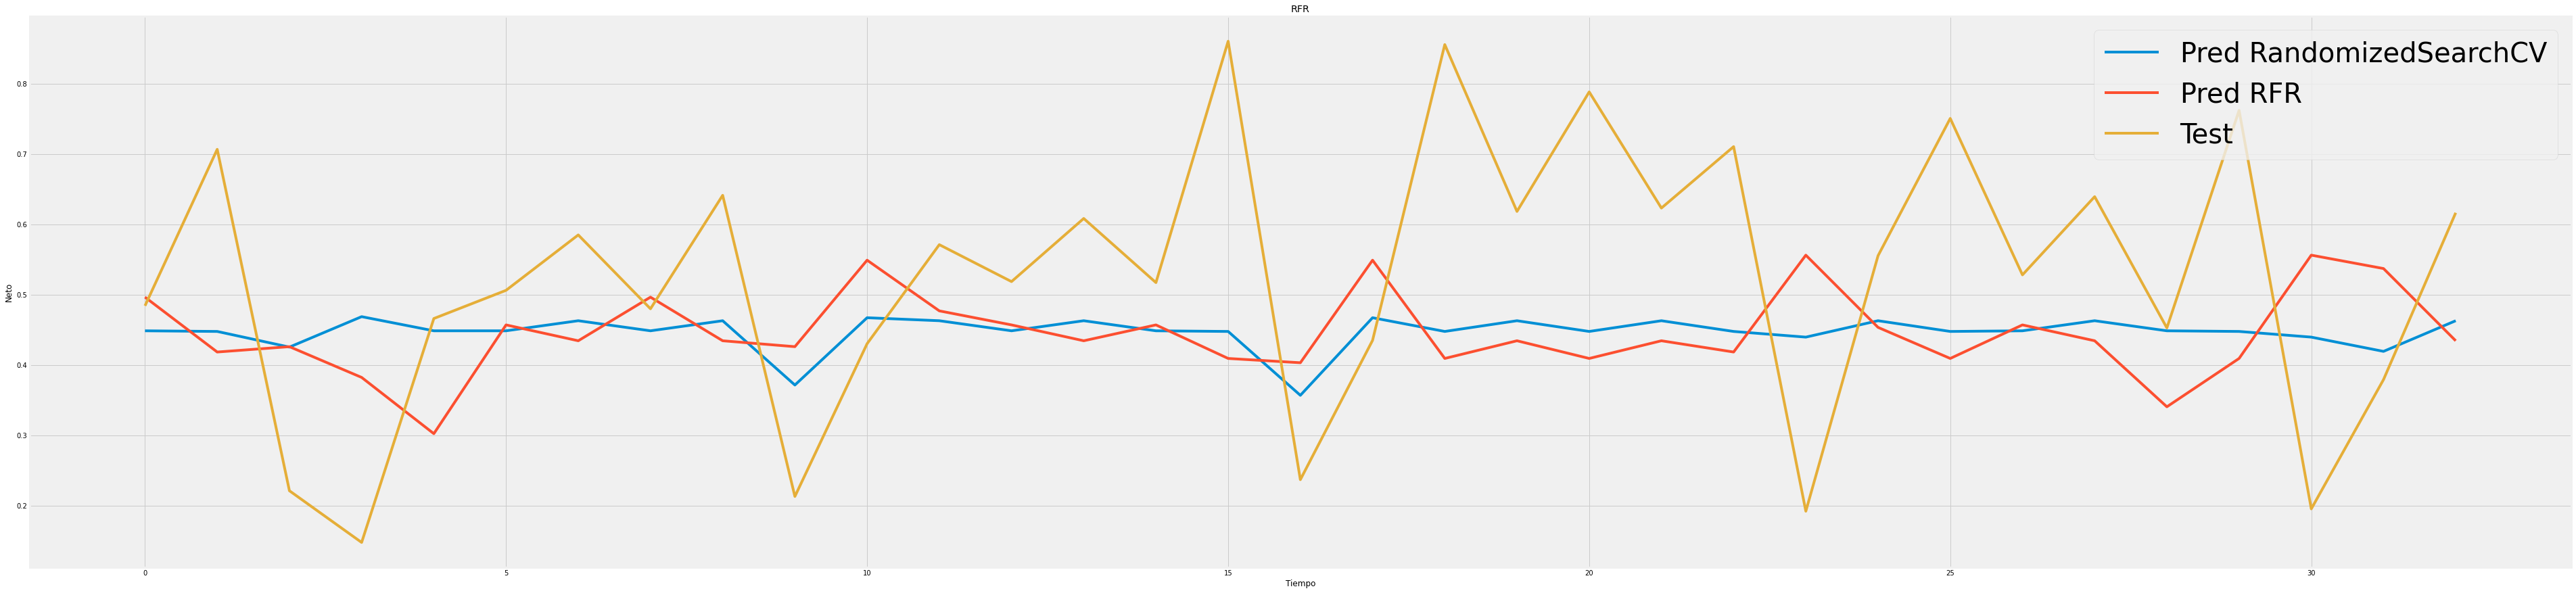

In [ ]:
fig = plt.subplots(1, 1,figsize=(60,15))
plt.title('RFR') 
plt.xlabel('Tiempo') 
plt.ylabel('Neto') 
#plt.plot(train_data2, label = 'train')
plt.plot(prediccion1, label = 'Pred RandomizedSearchCV')
'''plt.plot(prediccion2, label = 'Pred RFR')'''
plt.plot(prediccion3, label = 'Pred RFR')
'''plt.plot(prediccion4, label = 'Pred 4')'''
plt.plot(test_neto, label = 'Test')
plt.legend(prop={'size': 40})

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

print('Test 1')
print('MAE:',mean_absolute_error(prediccion1, test_neto))
print('MSE:',mean_squared_error(prediccion1, test_neto) )
'''print('Test 2')
print('MAE:',mean_absolute_error(prediccion2, test_neto))
print('MSE:',mean_squared_error(prediccion2, test_neto) )'''
print('Test 2')
print('MAE:',mean_absolute_error(prediccion3, test_neto))
print('MSE:',mean_squared_error(prediccion3, test_neto) )
'''print('Test 4')
print('MAE:',mean_absolute_error(prediccion4, test_neto))
print('MSE:',mean_squared_error(prediccion4, test_neto) )'''

Test 1
MAE: 0.16251073439687252
MSE: 0.039514622223679206
Test 2
MAE: 0.19760826784160004
MSE: 0.05320995013971962


"print('Test 4')\nprint('MAE:',mean_absolute_error(prediccion4, test_neto))\nprint('MSE:',mean_squared_error(prediccion4, test_neto) )"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from math import sqrt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
n_estimators=[5,10,100,200]
max_features=['auto','sqrt','log2']
max_depth=[3,4,5,6]
max_depth.append(None)
min_samples_split=[100,200,300]

grid_param = {'n_estimators':n_estimators,
              'max_features':max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split}

In [ ]:
train = df_mas[0:int(len(df_mas)*0.9)]
test = df_mas[int(len(df_mas)*0.9):]

x_train = train.iloc[:, 1:2].values #neto
y_train = train.iloc[:, 0].values #id
x_test = test.iloc[:, 1:2].values #neto
y_test = test.iloc[:, 0].values #id

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
RFR=RandomForestRegressor(random_state=1)
RFR_random = RandomizedSearchCV(estimator = RFR,
                                param_distributions = grid_param,
                                n_iter = 1000, cv = 5, verbose = 5, 
                                random_state = 42, n_jobs = -1)

RFR_random.fit(x_train, y_train)
print(RFR_random.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'n_estimators': 10, 'min_samples_split': 200, 'max_features': 'auto', 'max_depth': 3}


#Conjunto de datos elevado

####A continuación se muestra una parte del código utilizado para conjuntos de datos elevados extraido del código general implementado en la empresa por lo que las llamadas a las BBDD, visualización de resultados BI y otras funcionalidades no se pueden mostrar.

In [ ]:
db_user = os.getenv('SECRET_USERNAME', 'postgres')
db_pass = os.getenv('SECRET_PASSWORD', 'postgres')
engine = create_engine('postgresql://{}:{}@localhost:5432/asuma'.format(db_user, db_pass))


def is_weekday(ds):
    date = pd.to_datetime(ds)
    return (date.weekday() < 5)


def predict(producto, variable, m, connection):
    future = m.make_future_dataframe(periods=MONTHS_TO_PREDICT, freq='M', include_history=True)
    future['ds'] = future['ds'].dt.to_period('M').dt.to_timestamp()
    future = future.drop_duplicates()
    forecast = m.predict(future)

    fig = m.plot(forecast)

    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    json_forecast = json.loads(forecast.to_json(orient='records'))
    trans = connection.begin()

    try:
        for index, row in forecast.iterrows():
            s = text(
                "insert into ctr_predictions (cod_producto_id, variable, estamp, prediction) values ( :da, :va, :es, :pre)")
            result = connection.execute(s, da=producto, va=variable, es=row['ds'],
                                        pre=json.dumps([json_forecast[index], ]))
        trans.commit()
    except:
        trans.rollback()
        raise


def get_outliers(producto, variable, entrada, contrato):
    now = str(datetime.datetime.now().isoformat())
    from dateutil.relativedelta import relativedelta

    ago = datetime.datetime.now() - relativedelta(months=MONTHS)
    ago = str(ago.isoformat()) 
    sql = f"select sum({variable}), min(date_trunc('MONTH',fecha)::timestamp without time zone)" \
          f" from ctr_tickets where cod_producto_id='{producto}' and contrato_id='{contrato}'" \
          f" and fecha_salida between '{ago}' and '{now}' GROUP BY date_trunc('MONTH',fecha)::DATE" \
          f" order by  date_trunc('MONTH',fecha)::DATE"

    with engine.connect() as conn:
        trans = conn.begin()
        try:
            r = conn.execute(sql).fetchall()
        except:
            raise

        if len(r) > 7:
            all_data_orig = pd.DataFrame([var[0] for var in r], columns=[variable])
            all_data_orig.insert(0, 'stamp', [stamp for _, stamp in r])
            df = pd.DataFrame({
                'ds': all_data_orig['stamp'],
                'y': all_data_orig[variable]
            })

            df = df.replace([np.inf, -np.inf], np.nan)
            df = df.dropna()

            stddev = df['y'].std()
            mean = df['y'].mean()
            data_no_outliers = df[(df.y < (mean + 4 * stddev)) & (df.y > (mean - 4 * stddev))]

            if entrada and len(r) > 20:
                m = Prophet(seasonality_mode='additive')
                m.fit(df, iter=5000)
            if not entrada and (len(r) > 20 or producto == 37):
                m = Prophet(interval_width=0.95, yearly_seasonality=5)
                m.fit(data_no_outliers, iter=5000)
            else:
                m = Prophet(interval_width=0.95, yearly_seasonality=2)
                m.fit(data_no_outliers, iter=5000)

            return m
        else:
            raise